In [7]:
# Import libraries
import pandas as pd
import sys, os
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from transformers import pipeline

import re

In [2]:
# Function for output csv file
pd.options.mode.copy_on_write = True


def data_exploration(df_combined, months_folders, output_csv_path, columns_to_select):

    # Number of NaN values replaced
    nan_replaced_count = 0

    # For each month
    for month_folder in months_folders:
        # Start by importing "listings.csv"
        input_csv_path = os.path.join(month_folder, 'listings.csv')
        
        # The dataframe
        df = pd.read_csv(input_csv_path, low_memory=False)
        
        # Include only the columns that we want and are in the .csv file
        columns_to_keep = [col for col in columns_to_select if col in df.columns]
        df_selected = df[columns_to_keep]
        
        # Columns from other .csv files
        additional_columns = set()
        
        # Check all other .csv files in the folder
        for filename in os.listdir(month_folder):
            if filename.endswith('.csv') and filename != 'listings.csv':  # We want .csv files but no the starting one, aka "listings.csv"
                file_path = os.path.join(month_folder, filename)
                other_df = pd.read_csv(file_path)

                # Iterate over each column
                for col in other_df.columns:
                    # If we find a column that we want but is not already in our dataframe, add it from the other .csv file
                    if col not in df_selected.columns and col in columns_to_select:
                        additional_columns.add(col)
                        # Add the column and its data to our dataframe
                        df_selected[col] = other_df[col]

                    elif  col in df_selected.columns and col in columns_to_select:
                        # Check if any value of the column in our dataframe is NaN
                        nan_mask = df_selected[col].isna()
                        
                        # Check if the corresponding value in the other dataframes is not NaN
                        non_nan_mask = ~other_df[col].isna()
                        
                        # Replace NaN values with not NaN ones
                        df_selected.loc[nan_mask & non_nan_mask, col] = other_df.loc[nan_mask & non_nan_mask, col]

                        # Number of NaN values replaced
                        nan_replaced_count += sum(nan_mask & non_nan_mask)

        # Concatenate every months dataframes
        df_combined = pd.concat([df_combined, df_selected], ignore_index=True)

    # Write the final dataframe to the output .csv file
    df_combined.to_csv(output_csv_path, index=False)

    print(f"Data from all months has been written to {output_csv_path}")
    print(f"The output CSV file has {df_selected.shape[1]} columns.")
    #print(f"Number of NaN values replaced: {nan_replaced_count}")

    return df_combined

# Initialize a DataFrame to store data for 2019
dataframe_2019 = pd.DataFrame()

# Initialize a DataFrame to store data for 2023
dataframe_2023 = pd.DataFrame()

# Columns we want to select
columns_to_select_2019 = ['id', 'comments']

columns_to_select_2023 = ['id', 'comments']

### 2019 ###

# Each month's folder
months_folders = ['data/2019/april', 'data/2019/febrouary', 'data/2019/march']

# Path to the output CSV file
output_csv_path_2019 = 'data_train/train_2019.csv'

print("For 2019:")
dataframe_2019 = data_exploration(dataframe_2019, months_folders, output_csv_path_2019, columns_to_select_2019)

### 2023 ###

# Each month's folder
months_folders = ['data/2023/june', 'data/2023/march', 'data/2023/september']

# Path to the output CSV file
output_csv_path_2023 = 'data_train/train_2023.csv'

print("\nFor 2023:")
dataframe_2023 = data_exploration(dataframe_2023, months_folders, output_csv_path_2023, columns_to_select_2023)

For 2019:
Data from all months has been written to data_train/train_2019.csv
The output CSV file has 2 columns.

For 2023:
Data from all months has been written to data_train/train_2023.csv
The output CSV file has 2 columns.


In [3]:
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Preprocess text
def preprocess_text(text):
    # Numbers
    text = re.sub(r'\d+', '', text)
    # Lowercase and symbols
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Urls
    text = re.sub(r'http\S+', '', text)
    # Whitespaces
    text = text.strip()
    
    return text

# Stop words
def filter_stopwords(text, stop_words):
    words = text.split()
    filtered_words = []
    for word in words:
        if word.lower() not in stop_words:
            filtered_words.append(word)
    return ' '.join(filtered_words)

# Special characters
def clean_special_tags(text):
    # HTML tags
    clean_text = re.sub(r'<[^>]+>', '', text)
    # Keep only spaces and english characters
    clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text)
    return clean_text

# Function to detect language, so we keep only english language
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

# Drop nan values
dataframe_2019.dropna(subset=['comments'], inplace=True)
dataframe_2023.dropna(subset=['comments'], inplace=True)

# Download stop words
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Preprocess data by caling the functions above
dataframe_2019['comments'] = dataframe_2019['comments'].apply(preprocess_text)
dataframe_2023['comments'] = dataframe_2023['comments'].apply(preprocess_text)

dataframe_2019['comments'] = dataframe_2019['comments'].apply(filter_stopwords, stop_words = stop_words)
dataframe_2023['comments'] = dataframe_2023['comments'].apply(filter_stopwords, stop_words = stop_words)

dataframe_2019['comments'] = dataframe_2019['comments'].apply(clean_special_tags)
dataframe_2023['comments'] = dataframe_2023['comments'].apply(clean_special_tags)

# Filter out non-English comments
dataframe_2019 = dataframe_2019[dataframe_2019['comments'].apply(is_english)]
dataframe_2023 = dataframe_2023[dataframe_2023['comments'].apply(is_english)]

dataframe_2019 = dataframe_2019[dataframe_2019['comments'].str.strip().astype(bool)]
dataframe_2023 = dataframe_2023[dataframe_2023['comments'].str.strip().astype(bool)]

# Write to csv at /data_train/train... the final data we need, cleaned
dataframe_2019.to_csv(output_csv_path_2019, index=False)
dataframe_2023.to_csv(output_csv_path_2023, index=False)


[nltk_data] Downloading package stopwords to C:\Users\Erik
[nltk_data]     Kajacka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
import pandas as pd

# Load model, tokenizer, and config
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


# Function to analyze sentiment
def analyze_sentiment(data):
    results = []  # List to store results
    for idx, comment in zip(data['id'], data['comments']):  # Loop through each comment and its ID
        encoded_input = tokenizer(comment, return_tensors='pt', truncation=True, max_length=128)    # Tokenize the comment for input for the model
        output = model(**encoded_input)  # Model's output
        scores = output.logits.detach().numpy()[0]  # Detach the logits and convert to numpy
        scores = softmax(scores)  # Apply softmax to get the probability distribution over sentiment classes
        ranking = np.argsort(scores)[::-1]  # Sort in descending order
        sentiment = config.id2label[ranking[0]]  # Get the highest score
        results.append({'id': idx, 'review': comment, 'sentiment': sentiment})  # Append the result to the list
    return pd.DataFrame(results)    # Return the list as a dataframe


# Word lists for filtering
positive_words = ["great", "awesome", "glad", "happy", "fantastic", "good", "excellent", "amazing",
                  "beautiful", "wonderful", "superb", "perfect", "delightful", "joyful", "splendid",
                  "marvelous", "terrific", "brilliant", "phenomenal", "fabulous", "vibrant", "positive",
                  "uplifting", "lovely", "ideal", "satisfying", "outstanding", "magnificent", "stellar",
                  "glorious", "radiant", "blissful", "ecstatic", "content", "thrilled", "charming", "sweet",
                  "heartwarming", "kind", "grateful", "optimistic", "inspiring", "remarkable", "captivating"]

negative_words = ["terrible", "awful", "gross", "dirty", "disappointed", "bad", "poor", "horrible",
                  "unpleasant", "unfortunate", "miserable", "distressing", "inferior", "grim", "bleak",
                  "unacceptable", "dreadful", "lousy", "painful", "sorrowful", "regrettable", "tragic",
                  "depressing", "dismal", "unsatisfactory", "heartbreaking", "unfavorable", "atrocious",
                  "abysmal", "deplorable", "pitiful", "abominable", "gloomy", "disheartening", "dreary",
                  "negative", "displeasing", "repugnant", "appalling", "detestable", "horrifying", "dire",
                  "shameful", "wretched", "unsuitable", "disgusting", "offensive"]

def count_positive_words(text):
    return sum(word in text for word in positive_words)

def count_negative_words(text):
    return sum(word in text for word in negative_words)

# Classify reviews based on word counts
def classify_review(row):
    if row['positive_word_count'] > row['negative_word_count']:
        return 'positive'
    elif row['negative_word_count'] > row['positive_word_count']:
        return 'negative'
    else:
        return 'neutral'

# Sample the data with the desired distribution
def sample_with_distribution(df, pos_samples, neg_samples, neu_samples):
    
    positive_reviews = df[df['initial_sentiment'] == 'positive'].sample(n=pos_samples, random_state=42)
    negative_reviews = df[df['initial_sentiment'] == 'negative'].sample(n=neg_samples, random_state=42)
    neutral_reviews = df[df['initial_sentiment'] == 'neutral'].sample(n=neu_samples, random_state=42)
    
    return pd.concat([positive_reviews, negative_reviews, neutral_reviews])

# Load dataframes
dataframe_2019 = pd.read_csv("data_train/train_2019.csv")
dataframe_2023 = pd.read_csv("data_train/train_2023.csv")

# Initial filtering based on word counts, 2 new columns
dataframe_2019['positive_word_count'] = dataframe_2019['comments'].apply(count_positive_words)
dataframe_2019['negative_word_count'] = dataframe_2019['comments'].apply(count_negative_words)

dataframe_2023['positive_word_count'] = dataframe_2023['comments'].apply(count_positive_words)
dataframe_2023['negative_word_count'] = dataframe_2023['comments'].apply(count_negative_words)

# Final sentiment based on word counts
dataframe_2019['initial_sentiment'] = dataframe_2019.apply(classify_review, axis=1)
dataframe_2023['initial_sentiment'] = dataframe_2023.apply(classify_review, axis=1)


# Sample the data with the desired distribution
sample_df_2019 = sample_with_distribution(dataframe_2019, 500, 250, 250)
sample_df_2023 = sample_with_distribution(dataframe_2023, 500, 250, 250)

# Analyze sentiment for the sampled data based on model
sentiment_df_2019 = analyze_sentiment(sample_df_2019[['id', 'comments']])
sentiment_df_2023 = analyze_sentiment(sample_df_2023[['id', 'comments']])

# Filter out 300 rows where "comments" is "positive" in the analyzed sentiment. We do this so we have 60/20/20 percentages
positive_comments_2019 = sentiment_df_2019[sentiment_df_2019['sentiment'] == 'positive'].sample(n=400, random_state=42)
sentiment_df_2019 = sentiment_df_2019.drop(positive_comments_2019.index)

positive_comments_2023 = sentiment_df_2023[sentiment_df_2023['sentiment'] == 'positive'].sample(n=400, random_state=42)
sentiment_df_2023 = sentiment_df_2023.drop(positive_comments_2023.index)

# Save results to CSV
sentiment_df_2019.to_csv("data_sentiment/sentiment_2019.csv", index=False)
sentiment_df_2023.to_csv("data_sentiment/sentiment_2023.csv", index=False)

# Calculate sentiment counts
sentiment_counts_2019 = sentiment_df_2019['sentiment'].value_counts()
sentiment_counts_2023 = sentiment_df_2023['sentiment'].value_counts()

# Print sentiment counts
print("Sentiment counts for 2019:")
print(sentiment_counts_2019)
print("\nSentiment counts for 2023:")
print(sentiment_counts_2023)


c:\Users\Erik Kajacka\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Sentiment counts for 2019:
sentiment
positive    415
neutral     101
negative     84
Name: count, dtype: int64

Sentiment counts for 2023:
sentiment
positive    445
neutral      86
negative     69
Name: count, dtype: int64


Graph of 2019


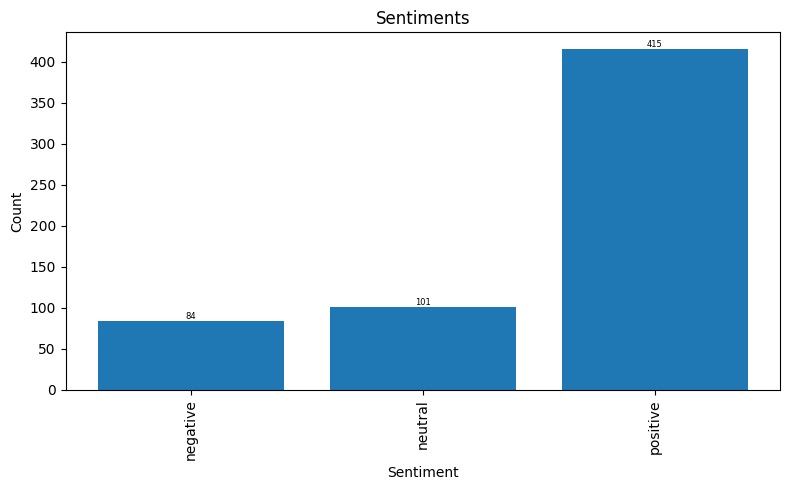


Graph of 2023


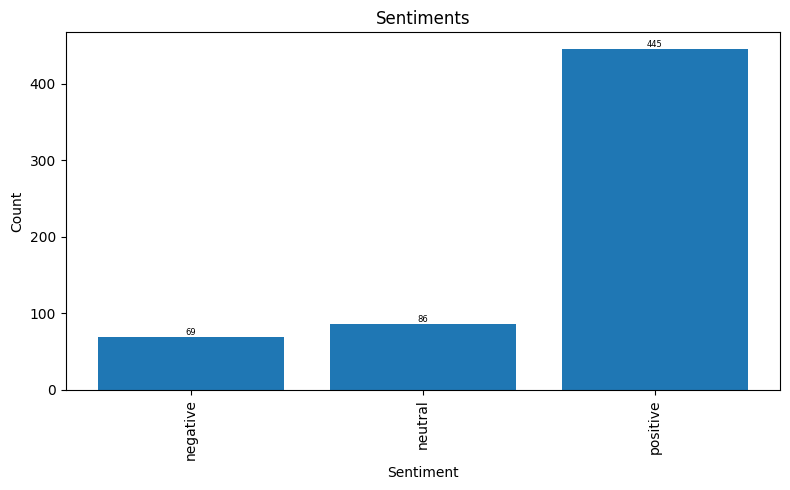

In [13]:

def mk_graph(df):
    temp_df = df.copy()
    
    sentiments = temp_df.groupby(['sentiment'], observed=False)['id'].count()

    sentiment_total_counts = sentiments.groupby('sentiment', observed=False).sum()
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.bar(sentiment_total_counts.index.get_level_values('sentiment'), sentiment_total_counts)

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # Set labels and title
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title('Sentiments')

    for i, count in enumerate(sentiment_total_counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=6)

    # Show the plot
    plt.tight_layout()
    plt.show()

# 2019
print("Graph of 2019")
mk_graph(sentiment_df_2019)

# 2023
print("\nGraph of 2023")
mk_graph(sentiment_df_2023)